# A Steam reviews classifier using Naive Bayes

<div style="text-align: justify">
Steam is a digital platform for the purchase of video games online. It is run by video game developer Valve.

Steam is one of the main options for purchasing video games online and has millions of active users every month.

One of the most important features of Steam is its review system. This system helps the user to decide whether to buy a game or not based on the experiences and recommendations of buyers of the game.

The review system classifies reviews as positive or negative, and cumulative reviews are classified as overhwelmingly positive, very positive, mostly positive, positive, mixed, overhwelmingly negative, very negative, mostly negative and negative.

</div>

This notebook presents step by step how to build a review classifier system using the **Naïve Bayes algorithm**.

## Importing dataset
The data to train the model were obtained from the "Steam Reviews" (Sobkowicz A., 2017) dataset available in Kaggle.

In [2]:
import pandas as pd

steam_reviews = pd.read_csv('/kaggle/input/steam-reviews/dataset.csv') 

In [5]:
steam_reviews.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


## Exploratory data analysis

Once, we have imported the dataset is time to analyze the features and their content starting from the features names.

In [32]:
list(steam_reviews.columns)

['app_id', 'app_name', 'review_text', 'review_score', 'review_votes']

- app_id: Game ID.
- app_name: Game name.
- review_text: Text of the review.
- review_score: Whether the review recommends the game or not.
- review_votes: Whether the review was recommended by another user or not.

Let's explore the number of games.

In [33]:
games = pd.unique(steam_reviews['app_name'])
games_count = len(games)
games_count

9364

Now, I will randomly select ten games to analyze and classify.

In [77]:
import numpy as np

np.random.seed(2810)
sample_size = 10

sampled_id = np.random.randint(0, games_count, sample_size)

sampled_games = list(games[sampled_id])
sampled_games

['Metro: Last Light Redux',
 'Metro 2033 Redux',
 'Rust',
 'Oozi: Earth Adventure',
 'Men of War: Vietnam',
 'Watch_Dogs',
 'Ostrich Island',
 'Mysterious Castle',
 'Air Brawl',
 'Death and the Fly']

Count number of reviews per game

In [78]:
games_data = steam_reviews.query("app_name in @sampled_games")

Rows per game

In [89]:
games_data.groupby('app_name').size()

app_name
Air Brawl                    557
Death and the Fly              7
Men of War: Vietnam          250
Metro 2033 Redux            4250
Metro: Last Light Redux     3233
Mysterious Castle              8
Oozi: Earth Adventure        204
Ostrich Island               132
Rust                       77037
Watch_Dogs                  8261
dtype: int64

Review score proportions by game

In [93]:
games_data.groupby('app_name')['review_score'].value_counts().unstack(1)

review_score,-1,1
app_name,,
Air Brawl,138,419
Death and the Fly,5,2
Men of War: Vietnam,108,142
Metro 2033 Redux,559,3691
Metro: Last Light Redux,302,2931
Mysterious Castle,6,2
Oozi: Earth Adventure,37,167
Ostrich Island,16,116
Rust,16005,61032


In [147]:
import numpy as np

negative = games_data.groupby('app_name')['review_score'].apply(lambda x: (x==-1).sum()).reset_index(name='negative')
positive = games_data.groupby('app_name')['review_score'].apply(lambda x: (x==1).sum()).reset_index(name='positive')

games_reviews_count = negative.join(positive["positive"])
games_reviews_count["log_negative"] = np.log(games_reviews_count["negative"])
games_reviews_count["log_positive"] = np.log(games_reviews_count["positive"])
games_reviews_count 

,app_name,negative,positive,log_negative,log_positive
0,Air Brawl,138,419,4.927254,6.037871
1,Death and the Fly,5,2,1.609438,0.693147
2,Men of War: Vietnam,108,142,4.682131,4.955827
3,Metro 2033 Redux,559,3691,6.326149,8.213653
4,Metro: Last Light Redux,302,2931,5.710427,7.983099
5,Mysterious Castle,6,2,1.791759,0.693147
6,Oozi: Earth Adventure,37,167,3.610918,5.117994
7,Ostrich Island,16,116,2.772589,4.753590
8,Rust,16005,61032,9.680656,11.019154
9,Watch_Dogs,3439,4822,8.142936,8.480944


<AxesSubplot:ylabel='app_name'>

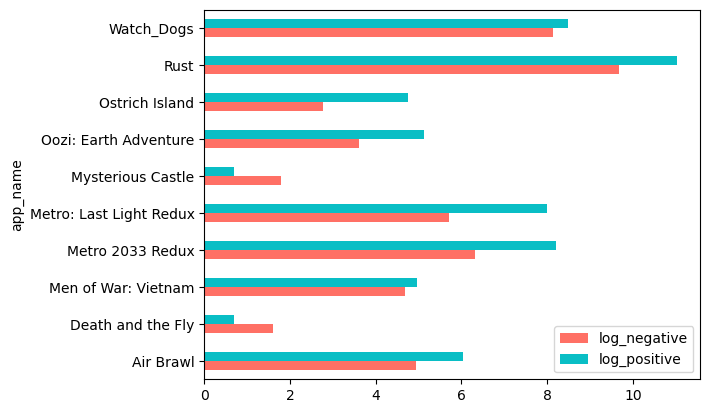

In [159]:
games_reviews_count.plot(x="app_name", y=["log_negative", "log_positive"], kind="barh", color=["#FF7065", "#09BEC5"])

Note: In this case I applied the log transformation to the count to compress the y-axis range. 